This notebook makes some statistics figures summarising the data and alignments

In [30]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import matplotlib.gridspec as gridspec
import seaborn as sns


def add_subplot_label(idx, subplot, start_character, **kwargs):
    """
    Adds A B C ... to upper left corner of a subplot...
    """
    offset = kwargs.pop("offset", (0,0))
    fontsize = kwargs.pop("fontsize", 12)
    label = kwargs.pop("label", None)

    subplot_label = chr(ord(start_character)+idx) if label is None else label
    xoff, yoff = offset

    subplot.annotate(
                xy = (-0.1+xoff,1.03+yoff), 
                text = subplot_label, 
                xycoords = "axes fraction",
                weight = "bold", 
                fontsize = fontsize
            )


<AxesSubplot:xlabel='sample'>

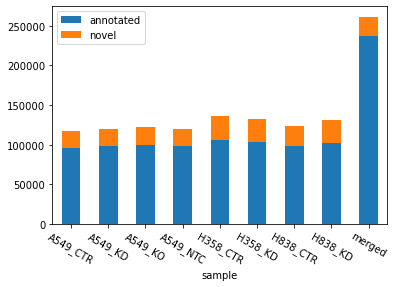

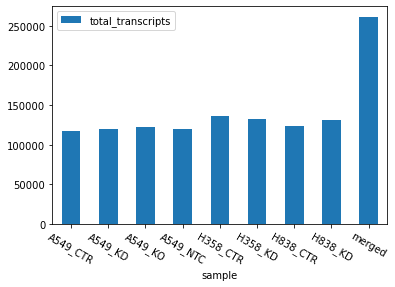

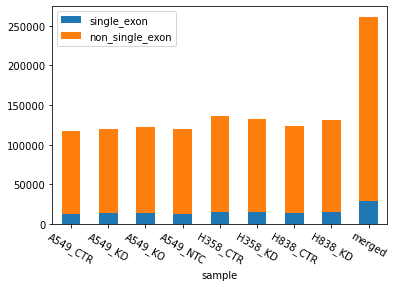

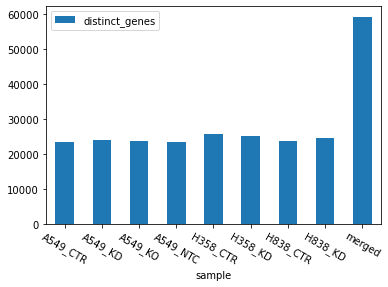

In [6]:
# Figure for STRINGTIE Transcript Mappings
stringtie_stats = pd.read_csv("../data/Stats/grep_stats_gtf.csv")

# uniquely mapped and unmapped reads
stringtie_stats.plot.bar(y = ["annotated", "novel"], x = "sample", stacked=True, rot = -30)

# number of transcripts in the assembly
# the transcripts + novel plot below replaces this one...
stringtie_stats.plot.bar(y = ["total_transcripts"], x = "sample", stacked=True, rot = -30)


# number of transcripts of single-exons vs multiple
stringtie_stats["non_single_exon"] = stringtie_stats["total_transcripts"] - stringtie_stats["single_exon"]
stringtie_stats.plot.bar(y = ["single_exon", "non_single_exon"], x = "sample", stacked=True, rot = -30)



# number of genes annotated with reads
stringtie_stats.plot.bar(y = "distinct_genes", x = "sample", stacked=True, rot = -30)


In [7]:
stringtie_stats
stringtie_stats["single_exon"] / stringtie_stats["non_single_exon"]

0    0.122049
1    0.121685
2    0.117884
3    0.118473
4    0.119933
5    0.120041
6    0.122637
7    0.122155
8    0.120639
dtype: float64

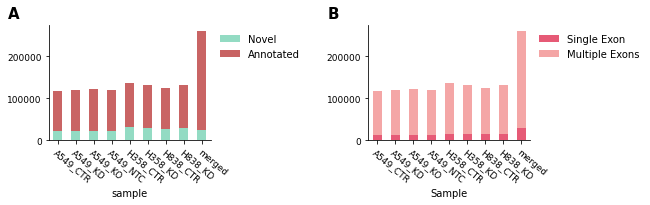

In [8]:
# Assemble a nice STRINGTIE summary reads figure

# some data preprocessing (from an older version of the stats script...)
if "sample" not in stringtie_stats.columns:
    stringtie_stats = stringtie_stats.sort_values("cell_line")
    stringtie_stats = stringtie_stats.rename(columns={"cell_line" : "sample"})
    stringtie_stats["cell_line"] = stringtie_stats["sample"].apply(lambda x: x.split("_")[0])
stringtie_stats["condition"] = stringtie_stats["sample"].apply(lambda x: x.split("_")[1] if "_" in x else x)


fig = plt.figure(figsize = (13, 3))

grid = fig.add_gridspec(3, 3)

# ax_mapped_reads = [fig.add_subplot(grid[i, 0]) for i in range(len(set(stringtie_stats["cell_line"])))]

# ax_mapped_reads = fig.add_subplot(grid[:, 0])
ax_transcript_overview = fig.add_subplot(grid[:, 1])
ax_genes_mapped = fig.add_subplot(grid[:, 2])

axs = [ax_transcript_overview, ax_genes_mapped]

# mapped reads
# stringtie_stats.plot.bar(
#                             y = ["mapped", "unmapped"], 
#                             x = "sample", stacked=True, rot = -30,
#                             ax = ax_mapped_reads, 
#                             ylabel = "Reads"
#                         )

# transcripts in assembly
stringtie_stats.plot.bar(
                            ax = ax_transcript_overview,
                            y = ["novel", "annotated"], 
                            x = "sample", stacked = True, rot = -30,
                            label = ["Novel", "Annotated"],
                            fontsize = 9,
                            color = ["mediumaquamarine", "firebrick"],
                            alpha = 0.7

                        )  

# single exons in assembly
stringtie_stats.plot.bar(
                            ax = ax_genes_mapped,
                            y = ["single_exon", "non_single_exon"], 
                            x = "sample", stacked=True, 
                            label = ["Single Exon", "Multiple Exons"],
                            xlabel = "Sample",
                            fontsize = 9, 
                            color = ["crimson", "lightcoral"],
                            alpha = 0.7,
                        )

idx = 0
for a in axs: 
    add_subplot_label(idx, a, "A", offset=(-0.15,0.03), fontsize = 15)
    # rotate x axis labels
    plt.setp( a.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor") 
    a.legend(loc="upper left", bbox_to_anchor = (1,1), frameon=False)
    idx += 1


sns.despine()
plt.tight_layout()
plt.savefig(fname = "Plots/stringtie_summary.pdf", bbox_inches = "tight")

In [9]:
stringtie_stats

sample  total_entries  total_transcripts  distinct_genes  annotated  \
0  A549_CTR         928174             117005           23392      96002   
1   A549_KD         954286             119925           24042      97906   
2   A549_KO         972820             122045           23745      99188   
3  A549_NTC         955637             120171           23532      97632   
4  H358_CTR        1076472             136661           25749     105653   
5   H358_KD        1044984             132819           25199     103014   
6  H838_CTR         970641             123654           23839      98027   
7   H838_KD        1031039             130960           24450     102220   
8    merged        2042241             261770           59375     236763   

   novel  single_exon  non_single_exon condition  
0  21003        12727           104278       CTR  
1  22019        13010           106915        KD  
2  22857        12870           109175        KO  
3  22539        12729           107442       NTC  
4  31008        14635           122026       CTR  
5  29805        14235           118584        KD  
6  25627        13508           110146       CTR  
7  28740        14256           116704        KD  
8  25007        28180           233590    merged

In [10]:
# read CPAT results
cpat_results = pd.read_table("../data/CPAT/CPAT.ORF_prob.best.tsv")

upper_threshold = 0.9
lower_threshold = 0.1

labels = [
            f"p > {upper_threshold}", 
            f"{upper_threshold} > p > {lower_threshold}",
            f"p < {lower_threshold}",
]

prop_classification = lambda x: "0" if x > upper_threshold else ("1" if upper_threshold > x > lower_threshold else "2" )

cpat_results["label"] = cpat_results["Coding_prob"].apply(prop_classification)


<AxesSubplot:>

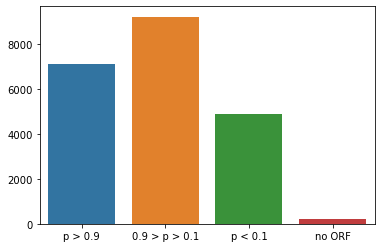

In [11]:
fig, ax = plt.subplots()

# cpat_results.plot.scatter(x = "Fickett", y = "Coding_prob", ax = ax, alpha = cpat_results["Coding_prob"], c = "lightgray")
# sns.scatterplot(data = subset, x = "ID", y = "Coding_prob", hue = "ORF_strand", ax = ax, alpha = 0.5)
# subset.plot.scatter(x = "Fickett", y = "Coding_prob", ax = ax, c = "blue", alpha = 0.5)

# get number of transcripts without identifiyable ORF
with open("../data/CPAT/CPAT.no_ORF.txt", "r") as f: 
    no_orfs = len(f.readlines())

# labels = sorted(list(set(cpat_results["label"])), key = lambda x: float(x[-1]), reverse = True)
counts = [len(cpat_results.query(f"label == '{i}'")) for i in range(len(labels))]

counts.append(no_orfs)
labels.append("no ORF")

novel_summary_df = pd.DataFrame(dict(
                                    label = labels, 
                                    count = counts,
                                ))

sns.barplot( 
            x = labels, 
            y = counts, 
            label = labels 
        )

# ax.set(xticks=[])

In [12]:
novel_summary_df

label  count
0        p > 0.9   7099
1  0.9 > p > 0.1   9219
2        p < 0.1   4874
3         no ORF    201

In [13]:
cpat_results

seq_ID  \
0      TRANSCRIPT::GL000008.2:150519-156194   
1        TRANSCRIPT::GL000009.2:58305-62189   
2       TRANSCRIPT::GL000009.2:83043-122625   
3       TRANSCRIPT::GL000009.2:98170-124839   
4       TRANSCRIPT::GL000194.1:53586-115067   
...                                     ...   
21187    TRANSCRIPT::CHRY:57206736-57212230   
21188    TRANSCRIPT::CHRY:57206738-57212230   
21189    TRANSCRIPT::CHRY:57206743-57212230   
21190    TRANSCRIPT::CHRY:57207480-57212230   
21191    TRANSCRIPT::CHRY:57207480-57209886   

                                                ID   mRNA ORF_strand  \
0      TRANSCRIPT::GL000008.2:150519-156194_ORF_10   5675          +   
1         TRANSCRIPT::GL000009.2:58305-62189_ORF_9   3884          -   
2        TRANSCRIPT::GL000009.2:83043-122625_ORF_2  39582          -   
3        TRANSCRIPT::GL000009.2:98170-124839_ORF_1  26669          -   
4        TRANSCRIPT::GL000194.1:53586-115067_ORF_1  61481          +   
...                                            ...    ...        ...   
21187     TRANSCRIPT::CHRY:57206736-57212230_ORF_2   5494          +   
21188     TRANSCRIPT::CHRY:57206738-57212230_ORF_2   5492          +   
21189     TRANSCRIPT::CHRY:57206743-57212230_ORF_2   5487          +   
21190     TRANSCRIPT::CHRY:57207480-57212230_ORF_2   4750          +   
21191     TRANSCRIPT::CHRY:57207480-57209886_ORF_1   2406          +   

       ORF_frame  ORF_start  ORF_end  ORF  Fickett   Hexamer  Coding_prob  \
0              1       3037     3231  195   1.0554  0.240208     0.296871   
1              2       1726     1532  195   1.0760  0.234946     0.326302   
2              2       9206     8622  585   0.9007  0.071869     0.521746   
3              3      17382    16675  708   0.5102  0.002573     0.599780   
4              3       4368     5093  726   0.7821  0.078496     0.523769   
...          ...        ...      ...  ...      ...       ...          ...   
21187          3       2541     3062  522   0.8557  0.216900     0.878282   
21188          1       2539     3060  522   0.8557  0.216900     0.878293   
21189          2       2534     3055  522   0.8557  0.216900     0.878323   
21190          3       1797     2318  522   0.8557  0.216900     0.882576   
21191          3       1797     2318  522   0.8557  0.216900     0.895255   

      label  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
21187     1  
21188     1  
21189     1  
21190     1  
21191     1  

[21192 rows x 12 columns]

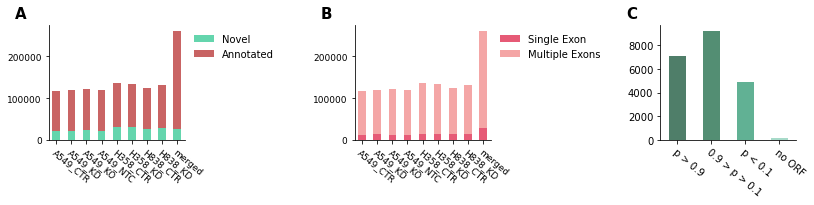

In [14]:

fig = plt.figure(figsize = (15, 3))

grid = fig.add_gridspec(3, 4)

# ax_mapped_reads = fig.add_subplot(grid[:, 0])
ax_transcript_overview = fig.add_subplot(grid[:, 1])
ax_genes_mapped = fig.add_subplot(grid[:, 2])
ax_novel_transcripts = fig.add_subplot(grid[:, 3])

axs = [ax_transcript_overview, ax_genes_mapped, ax_novel_transcripts]

# mapped reads
# stringtie_stats.plot.bar(
#                             y = ["mapped", "unmapped"], 
#                             x = "sample", stacked=True, rot = -30,
#                             ax = ax_mapped_reads, 
#                             ylabel = "Reads"
#                         )

# transcripts in assembly
stringtie_stats.plot.bar(
                            ax = ax_transcript_overview,
                            y = ["novel", "annotated"], 
                            x = "sample", stacked = True, rot = -30,
                            label = ["Novel", "Annotated"],
                            fontsize = 9,
                            color = ["xkcd:greenblue", "firebrick"],
                            alpha = 0.7

                        )  

# single exons in assembly
stringtie_stats.plot.bar(
                            ax = ax_genes_mapped,
                            y = ["single_exon", "non_single_exon"], 
                            x = "sample", stacked=True, 
                            label = ["Single Exon", "Multiple Exons"],
                            xlabel = "Sample",
                            fontsize = 9, 
                            color = ["crimson", "lightcoral"],
                            alpha = 0.7,
                        )

# coding probs of novel transcripts
novel_summary_df.plot.bar( 
                            ax = ax_novel_transcripts,
                            x = "label", 
                            y = "count", 
                            color = ["xkcd:evergreen", "xkcd:spruce", "xkcd:viridian", "xkcd:pale teal"],
                            alpha = 0.7,
                        )

idx = 0
for a in axs: 
    add_subplot_label(idx, a, "A", offset=(-0.15,0.03), fontsize = 15)
    # rotate x axis labels
    plt.setp( a.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor") 
    a.legend(loc="upper left", bbox_to_anchor = (1,1), frameon=False)
    a.set(xlabel = "")
    idx += 1

ax_novel_transcripts.legend().remove()

sns.despine()
plt.tight_layout()
plt.savefig(fname = "Plots/stats_summary.pdf", bbox_inches = "tight")

In [23]:
cpat_results.query("Coding_prob > 0.9")

seq_ID  \
17     TRANSCRIPT::GL000214.1:117116-118174   
19     TRANSCRIPT::GL000214.1:123253-124528   
21     TRANSCRIPT::GL000214.1:129613-130806   
26       TRANSCRIPT::GL000218.1:46987-56256   
34     TRANSCRIPT::GL000220.1:116843-119626   
...                                     ...   
21166      TRANSCRIPT::CHRY:2220772-2500816   
21167      TRANSCRIPT::CHRY:2486413-2500816   
21183    TRANSCRIPT::CHRY:19567349-19595111   
21184    TRANSCRIPT::CHRY:19567381-19595111   
21185    TRANSCRIPT::CHRY:19567381-19606274   

                                               ID    mRNA ORF_strand  \
17     TRANSCRIPT::GL000214.1:117116-118174_ORF_1    1058          -   
19     TRANSCRIPT::GL000214.1:123253-124528_ORF_1    1275          -   
21     TRANSCRIPT::GL000214.1:129613-130806_ORF_1    1193          -   
26       TRANSCRIPT::GL000218.1:46987-56256_ORF_1    9269          -   
34     TRANSCRIPT::GL000220.1:116843-119626_ORF_1    2783          -   
...                                           ...     ...        ...   
21166      TRANSCRIPT::CHRY:2220772-2500816_ORF_1  280044          -   
21167      TRANSCRIPT::CHRY:2486413-2500816_ORF_1   14403          -   
21183    TRANSCRIPT::CHRY:19567349-19595111_ORF_1   27762          -   
21184    TRANSCRIPT::CHRY:19567381-19595111_ORF_1   27730          -   
21185    TRANSCRIPT::CHRY:19567381-19606274_ORF_1   38893          -   

       ORF_frame  ORF_start  ORF_end   ORF  Fickett   Hexamer  Coding_prob  \
17             2        982        2   981   0.8353  0.016923     0.997696   
19             1       1143        1  1143   0.7309  0.016059     0.999451   
21             2       1066        2  1065   0.7174  0.013507     0.998609   
26             3       7227     6496   732   0.6753  0.213142     0.969940   
34             1       2417     1767   651   0.8640  0.244517     0.977342   
...          ...        ...      ...   ...      ...       ...          ...   
21166          2      62546    55770  6777   0.4241 -0.348350     1.000000   
21167          3       4306     2222  2085   1.2882  0.741987     1.000000   
21183          1      14757    13849   909   0.6496  0.015534     0.959009   
21184          1      14725    13817   909   0.6496  0.015534     0.959078   
21185          1      14725    13817   909   0.6496  0.015534     0.927050   

      label  
17        0  
19        0  
21        0  
26        0  
34        0  
...     ...  
21166     0  
21167     0  
21183     0  
21184     0  
21185     0  

[7099 rows x 12 columns]

In [15]:
base_qualities = pd.read_csv("../data/Stats/per_base_qualities.csv")
base_qualities["name"] = base_qualities["replicate"].apply(lambda x: x.split("_")[0])
base_qualities["name1"] = base_qualities["replicate"].apply(lambda x: "_".join(x.split("_")[:2]))

base_qualities

Base       Mean   replicate  name    name1
0        1  36.434611   HD1_L2_R1   HD1   HD1_L2
1        2  36.304246   HD1_L2_R1   HD1   HD1_L2
2        3  36.426085   HD1_L2_R1   HD1   HD1_L2
3        4  36.503428   HD1_L2_R1   HD1   HD1_L2
4        5  36.524550   HD1_L2_R1   HD1   HD1_L2
...    ...        ...         ...   ...      ...
4891    47  35.288865  HD21_L2_R2  HD21  HD21_L2
4892    48  35.284659  HD21_L2_R2  HD21  HD21_L2
4893    49  35.290844  HD21_L2_R2  HD21  HD21_L2
4894    50  35.305255  HD21_L2_R2  HD21  HD21_L2
4895    51  35.672321  HD21_L2_R2  HD21  HD21_L2

[4896 rows x 5 columns]

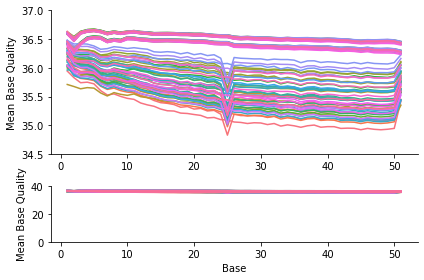

In [16]:
fig = plt.figure()

grid = fig.add_gridspec(6, 1)
ax1 = fig.add_subplot(grid[:4,0])
ax2 = fig.add_subplot(grid[4:,0])

sns.lineplot(ax = ax1, data = base_qualities, x = "Base", y = "Mean", 
hue = "replicate", 
units = "name", estimator = None)
sns.lineplot(ax = ax2, data = base_qualities, x = "Base", y = "Mean", 
hue = "replicate", 
units = "name", estimator = None)

ax1.set(ylim = (34.5, 37), xlabel="", ylabel = "Mean Base Quality")
ax2.set(ylim = (0, 40), ylabel = "Mean Base Quality")

ax2.legend().remove()
ax1.legend(frameon=True, bbox_to_anchor=(1.1,1)).remove()
plt.tight_layout()
sns.despine()

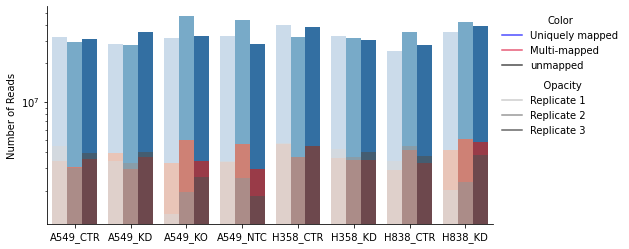

In [17]:
bam_stats = pd.read_csv("../data/Stats/grep_stats_bam.csv")
groups = pd.read_csv("../data/index.csv") # read index to add A549_CTR etc...
groups["sample_name"] = [f"{i}_{j}" for i, j in zip(groups["cell_line"], groups["condition"])]
bam_stats = bam_stats.merge(groups[["sample_name", "sample"]], on = "sample")
bam_stats = bam_stats.sort_values("sample_name")

rep = [1,2,3]
reps = []
for i in set(bam_stats["sample_name"]):
    reps.extend(rep)

bam_stats["rep"] = reps

fig, ax = plt.subplots(figsize = (8, 4))
sns.barplot( 
            data = bam_stats,  
            x = "sample_name", y = "uniquely_mapped", hue = "rep",  palette = "Blues", 
            ax = ax
)
sns.barplot(
            data = bam_stats, 
            x = "sample_name", y = "multi_mapped", hue = "rep",  palette = "Reds", alpha = 0.8,
            ax = ax
)
sns.barplot(
            data = bam_stats, 
            x = "sample_name", y = "unmapped", hue = "rep",  palette = "Greys", alpha = 0.6,
            ax = ax
)
ax.legend().remove()
ax.set(yscale = "log", ylabel = "Number of Reads", xlabel = "")
c_legend = plt.legend(
    handles = [
        Line2D([0], [0], color = "Blue", label = "Uniquely mapped", alpha = 0.7),
        Line2D([0], [0], color = "crimson", label = "Multi-mapped", alpha = 0.7),
        Line2D([0], [0], color = "black", label = "unmapped", alpha = 0.7),
    ],
    bbox_to_anchor = (1,1), frameon = False, title = "Color"
)
o_legend = plt.legend(
    handles = [
        Line2D([0], [0], color = "black", label = "Replicate 1", alpha = 0.2),
        Line2D([0], [0], color = "black", label = "Replicate 2", alpha = 0.4),
        Line2D([0], [0], color = "black", label = "Replicate 3", alpha = 0.6),
    ],
    bbox_to_anchor = (1,0.7), frameon = False, title = "            Opacity"
)
ax.add_artist(c_legend)
ax.add_artist(o_legend)
ax.legend().remove()
sns.despine()

In [18]:
bam_stats

sample  total_entries  mean_length  uniquely_mapped  multi_mapped  \
0     HD1       40423213       100.82         32431660       3445885   
17    HD3       35616829       100.84         29455741       3095331   
11    HD2       38810809       100.82         31274014       3518912   
20    HD6       36058244       100.82         28574546       3957883   
19    HD5       34392548       100.83         28125933       2938930   
18    HD4       42753432       100.82         34958772       3708223   
16   HD24       36354568       100.85         31716166       3282692   
15   HD23       53841167       100.85         46820784       4992274   
14   HD22       38933100       100.85         32879367       3421151   
13   HD21       39435984       100.84         32642526       3353327   
10   HD19       50980798       100.85         43751312       4637943   
12   HD20       32994643       100.85         28186212       2952790   
21    HD7       49734462       100.83         40182342       4668000   
23    HD9       39834079       100.81         32302583       3704913   
22    HD8       47976219       100.83         38870149       4479308   
1    HD10       40791411       100.81         32817804       3610847   
2    HD11       38690766       100.82         31375423       3512181   
3    HD12       38406651       100.82         30781957       3461832   
6    HD15       31245153       100.82         24820724       2893684   
5    HD14       43805503       100.83         35003199       4152979   
4    HD13       35243535       100.80         28038209       3322958   
9    HD18       41458983       100.83         35097713       4172938   
8    HD17       49878849       100.83         42224866       5130029   
7    HD16       48141891       100.80         39295126       4851076   

    unmapped  chimeric sample_name  rep  
0    4494833         0    A549_CTR    1  
17   3018346         0    A549_CTR    2  
11   3967333         0    A549_CTR    3  
20   3436878         0     A549_KD    1  
19   3278807         0     A549_KD    2  
18   4024471         0     A549_KD    3  
16   1312073         0     A549_KO    1  
15   1956872         0     A549_KO    2  
14   2584690         0     A549_KO    3  
13   3393906         0    A549_NTC    1  
10   2527523         0    A549_NTC    2  
12   1816229         0    A549_NTC    3  
21   4728486         0    H358_CTR    1  
23   3689981         0    H358_CTR    2  
22   4486928         0    H358_CTR    3  
1    4243358         0     H358_KD    1  
2    3683251         0     H358_KD    2  
3    4050853         0     H358_KD    3  
6    3429718         0    H838_CTR    1  
5    4500474         0    H838_CTR    2  
4    3769833         0    H838_CTR    3  
9    2038290         0     H838_KD    1  
8    2340855         0     H838_KD    2  
7    3821371         0     H838_KD    3

In [19]:
1/np.mean(bam_stats["total_entries"]/bam_stats["uniquely_mapped"])

0.8215688556590063

In [34]:

fig = plt.figure(figsize = (14, 5))

grid = fig.add_gridspec(2, 6)

ax_fastqc = fig.add_subplot(grid[
                                    1, 3:
                                ])

ax_bam = fig.add_subplot(grid[
                                    1, 0:3
                                ])

ax_gtf_transcripts = fig.add_subplot(grid[
                                    0, :2
                                ])
ax_gtf_exons = fig.add_subplot(grid[
                                    0, 2:4
                                ])

ax_gtf_genes = fig.add_subplot(grid[
                                    0, 4:
                                ])

axs = [ax_gtf_transcripts, ax_gtf_exons, ax_gtf_genes, ax_bam, ax_fastqc]

# FASTQc plot
sns.lineplot(
                ax = ax_fastqc, 
                data = base_qualities, x = "Base", y = "Mean", 
                hue = "replicate", alpha = 0.2,
                units = "name", estimator = None
            )
ax_fastqc.set(ylim = (0, 40), ylabel = "Mean Base Quality")


# BAM stats plot
sns.barplot( 
            data = bam_stats,  
            x = "sample_name", y = "uniquely_mapped", hue = "rep",  palette = "Blues", 
            ax = ax_bam
)
sns.barplot(
            data = bam_stats, 
            x = "sample_name", y = "multi_mapped", hue = "rep",  palette = "Reds", alpha = 0.8,
            ax = ax_bam
)
sns.barplot(
            data = bam_stats, 
            x = "sample_name", y = "unmapped", hue = "rep",  palette = "Greys", alpha = 0.6,
            ax = ax_bam
)

ax_bam.set(yscale = "log", ylabel = "Number of Reads", xlabel = "")

# transcripts in assembly
stringtie_stats.plot.bar(
                            ax = ax_gtf_transcripts,
                            y = ["novel", "annotated"], 
                            x = "sample", stacked = True, 
                            label = ["Novel", "Annotated"],
                            fontsize = 9, xlabel = "",
                            color = ["xkcd:greenblue", "firebrick"],
                            alpha = 0.7

                        )  

# single exons in assembly
stringtie_stats.plot.bar(
                            ax = ax_gtf_exons,
                            y = ["single_exon", "non_single_exon"], 
                            x = "sample", stacked=True, 
                            label = ["Single Exon", "Multiple Exons"],
                            xlabel = "", 
                            fontsize = 9, 
                            color = ["crimson", "lightcoral"],
                            alpha = 0.7,
                        )

# distinct genes in assembly
stringtie_stats.plot.bar(
                            ax = ax_gtf_genes,
                            y = "distinct_genes", x = "sample", 
                            label = "Distinct Genes",
                            stacked=True, 
                            rot = -30,
                            xlabel = "", 
                            fontsize = 9, 
                            color = "xkcd:faded purple",
                            alpha = 0.7,
                        )



idx = 0
for ax in axs: 
    ax.legend().remove()
    add_subplot_label(idx, ax, "A", fontsize = 12)
    idx += 1

for ax in axs[:4]:
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor") 
    ax.legend(loc="upper left", bbox_to_anchor = (1,1), frameon=False)
    # current_values = ax.get_yticks()
    # ax.set(yticklabels = ['{:.0e}'.format(x) for x in current_values])

# c_legend = ax_bam.legend(
#     handles = [
#         Line2D([0], [0], color = "Blue", linewidth = 6, label = "Uniquely mapped", alpha = 0.7),
#         Line2D([0], [0], color = "crimson", linewidth = 6, label = "Multi-mapped", alpha = 0.7),
#         Line2D([0], [0], color = "black", linewidth = 6, label = "Unmapped", alpha = 0.7),
#     ],
#     bbox_to_anchor = (1,1.2), frameon = False, title = "Color"
# )

c_legend = ax_bam.legend(
    handles = [
        Patch(facecolor = "xkcd:cobalt", edgecolor = None, label = "Uniquely mapped", alpha = 0.7),
        Patch(facecolor = "crimson", edgecolor = None, label = "Multi-mapped", alpha = 0.7),
        Patch(facecolor = "black", edgecolor = None, label = "Unmapped", alpha = 0.7),
    ],
    bbox_to_anchor = (1,1.2), frameon = False, title = "Color"
)
o_legend = ax_bam.legend(
    handles = [
        Patch(facecolor = "black", edgecolor = None, label = "Replicate 1", alpha = 0.2),
        Patch(facecolor = "black", edgecolor = None, label = "Replicate 2", alpha = 0.4),
        Patch(facecolor = "black", edgecolor = None, label = "Replicate 3", alpha = 0.6),
    ],
    bbox_to_anchor = (1,0.6), frameon = False, title = "            Opacity"
)
ax_bam.add_artist(c_legend)

sns.set_style("darkgrid")
sns.despine()
plt.tight_layout()
plt.savefig(fname = "Plots/stats_summary.jpg", dpi = 1000, bbox_inches = "tight")

SyntaxError: invalid syntax (207627256.py, line 84)